# Compute SNR

Calculate the SNR of the recordings in the test dataset.

(Rado's implementation of SNR functions is provided at the bottom of the notebook).

**Author**: Prisca Dotti  
**Last modified**: 26/10/2023

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import sys

# To import modules from parent directory in Jupyter Notebook
sys.path.append("..")

In [2]:
import logging
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import napari

from utils.in_out_tools import load_movies_ids, load_annotations_ids
from data.data_processing_tools import compute_snr, moving_average, keep_percentile

logger = logging.getLogger(__name__)

c:\Users\prisc\anaconda3\envs\sparks\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set working directories

In [7]:
# list of all movie IDs in test set
# sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
sample_ids = ["05", "34"]

relative_path = "../data/sparks_dataset"
dataset_path = os.path.realpath(f"{relative_path}")

#### Load recordings

In [8]:
# load movies
xs = load_movies_ids(
    data_folder=dataset_path, ids=sample_ids, names_available=True, movie_names="video"
)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [9]:
# load annotations
ys = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="class_label"
)

### Compute SNR

In [118]:
sample_id = sample_ids[1]
x = xs[sample_id]
y = ys[sample_id]

In [93]:
viewer = napari.Viewer()
viewer.add_image(x, name="x")
viewer.add_labels(y, name="y")
viewer.add_labels(cell_mask, name="cell_mask")

<Labels layer 'cell_mask' at 0x1f362a03f70>

In [31]:
snr = {}
for sample_id in sample_ids:
    # get sample
    x = xs[sample_id]
    # get annotations
    y = ys[sample_id]

    # compute signal-to-noise ratio
    snr[sample_id] = compute_snr(x, y)

c:\Users\dotti\.conda\envs\sparks\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dotti\.conda\envs\sparks\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [33]:
snr

{'05': 3.7602728066749176,
 '10': 5.246450626955872,
 '15': 3.6158439293276285,
 '20': 3.4844570216716546,
 '25': 2.9343785047995747,
 '32': 2.7851681242324617,
 '34': 7.538199364128073,
 '40': 4.162392377502107,
 '45': 4.117296906830039}

Text(0, 0.5, 'SNR')

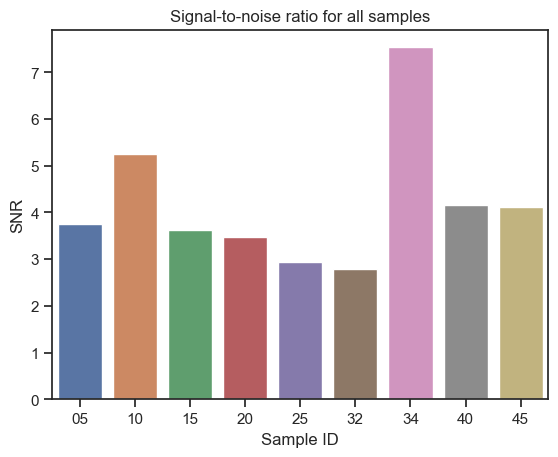

In [32]:
# plot snr for all samples using seaborn
sns.set_theme(style="ticks")
ax = sns.barplot(x=list(snr.keys()), y=list(snr.values()))
ax.set_title("Signal-to-noise ratio for all samples")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")

In [34]:
# visualize snr with respect to samples given to experts for inter-rater agreement
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}

movie_id_to_slice = {v: k for k, v in slice_to_movie_id.items()}
slice_ids = list(slice_to_movie_id.keys())

# get snr for samples given to experts
snr_experts = {slice_id: snr[slice_to_movie_id[slice_id]] for slice_id in slice_ids}

In [35]:
# print snr_experts as table
df_snr_experts = pd.DataFrame.from_dict(snr_experts, orient="index", columns=["snr"])
df_snr_experts = df_snr_experts.rename_axis("slice_id")
df_snr_experts = df_snr_experts.style.format(precision=2)
df_snr_experts

,snr
slice_id,
01,3.62
02,3.48
03,7.54
04,3.76
05,5.25
06,2.93
07,2.79
08,7.54
09,4.16


Text(0, 0.5, 'SNR')

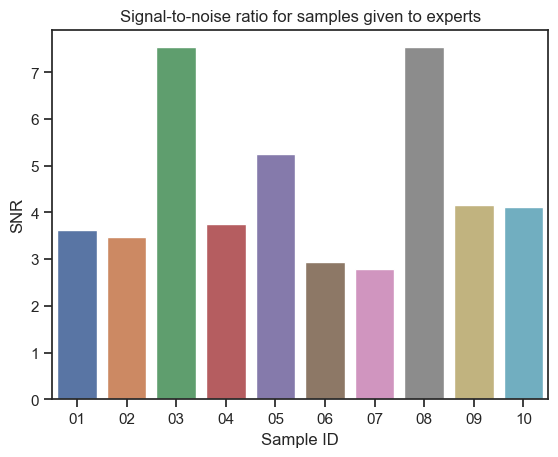

In [36]:
# visualize snr for samples given to experts
ax = sns.barplot(x=list(snr_experts.keys()), y=list(snr_experts.values()))
ax.set_title("Signal-to-noise ratio for samples given to experts")
ax.set_xlabel("Sample ID")
ax.set_ylabel("SNR")

Text(0, 0.5, "Fleiss' Kappa")

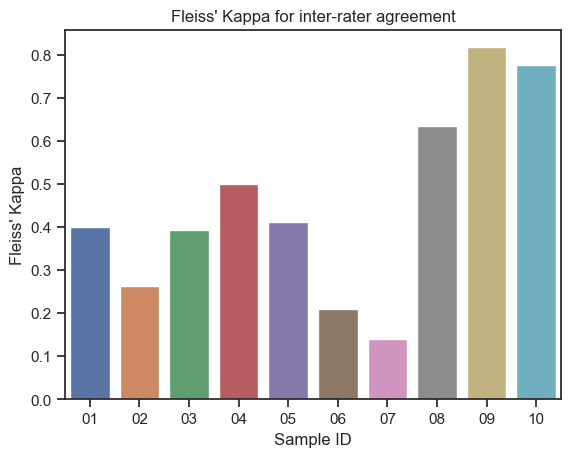

In [37]:
# Fleiss' Kappa for inter-rater agreement
fleiss_kappas = {
    "01": 0.4,
    "02": 0.263,
    "03": 0.393,
    "04": 0.499,
    "05": 0.411,
    "06": 0.210,
    "07": 0.140,
    "08": 0.635,
    "09": 0.817,
    "10": 0.776,
}

# visualize fleiss kappas as barplot
ax = sns.barplot(x=list(fleiss_kappas.keys()), y=list(fleiss_kappas.values()))
ax.set_title("Fleiss' Kappa for inter-rater agreement")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Fleiss' Kappa")

Pearsons correlation: 0.340


Text(0, 0.5, "Fleiss' Kappa")

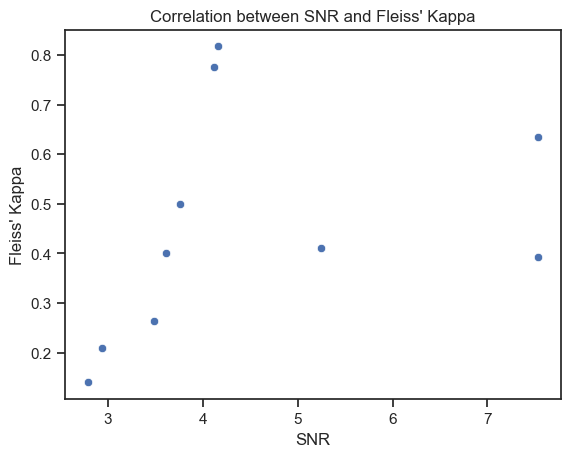

In [38]:
# check if there is a correlation between snr and fleiss kappas
snr_experts_list = list(snr_experts.values())
fleiss_kappas_list = list(fleiss_kappas.values())

corr, _ = pearsonr(snr_experts_list, fleiss_kappas_list)
print("Pearsons correlation: %.3f" % corr)

# visualize snr and fleiss kappas as scatterplot
ax = sns.scatterplot(x=snr_experts_list, y=fleiss_kappas_list)
ax.set_title("Correlation between SNR and Fleiss' Kappa")
ax.set_xlabel("SNR")
ax.set_ylabel("Fleiss' Kappa")

In [9]:
k = 75  # choose value k of percentile
n_iter = 2  # number of dilation/erosion iterations

#### Compute "percentile masks" of a list of movies

In [20]:
# compute new percentile mask for all movies and store them in a dict
percentile_masks = {}

In [26]:
# remaining_movie_ids = ["12","19","20","21"]
remaining_movie_ids = ["07"]

In [27]:
for sample_id in remaining_movie_ids:
    movie = xs[sample_id]
    class_mask = class_masks[sample_id]
    event_mask = event_masks[sample_id]

    # normalise input movie between 0 and 1
    movie = (movie - movie.min()) / (movie.max() - movie.min())

    # get event masks of sparks only
    spark_events_mask = np.where(class_mask == 1, event_mask, 0)

    # get spark events IDs
    spark_events_ids = list(np.unique(spark_events_mask))
    spark_events_ids.remove(0)

    print(f"List of sparks IDs in movie {sample_id}:", *spark_events_ids)

    # new events mask using percentile method
    percentile_events_mask = np.zeros_like(spark_events_mask)

    for spark_id in spark_events_ids:
        event_mask = spark_events_mask == spark_id

        # reduce sparks size dimension wrt to percentile
        new_event_mask = keep_percentile(
            movie=movie,
            event_mask=event_mask,
            k=k,
        )
        percentile_events_mask[new_event_mask] = spark_id

    percentile_masks[sample_id] = percentile_events_mask

List of sparks IDs in movie 07: 3573375 4342810 4385274 7251112 9400685 14726463 16370811


#### Run this to analyse a single mask

In [28]:
sample_id = "07"
movie = xs[sample_id]
class_mask = class_masks[sample_id]
event_mask = event_masks[sample_id]

# normalise input movie between 0 and 1
movie = (movie - movie.min()) / (movie.max() - movie.min())

# get original sparks mask and list of spark IDs
spark_events_mask = np.where(class_mask == 1, event_mask, 0)
spark_events_ids = list(np.unique(spark_events_mask))
spark_events_ids.remove(0)

print("List of sparks IDs:", *spark_events_ids)

# get percentile mask
percentile_events_mask = percentile_masks[sample_id]

List of sparks IDs: 3573375 4342810 4385274 7251112 9400685 14726463 16370811


In [29]:
np.unique(np.where(percentile_events_mask)[0])

array([ 64,  65,  66,  67,  68,  69,  72, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 407, 408, 409, 410, 411, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 479, 480],
      dtype=int64)

In [30]:
viewer = napari.Viewer()
viewer.add_image(movie, name="movie")
viewer.add_labels(spark_events_mask, name="spark events", opacity=0.2)
viewer.add_labels(
    percentile_events_mask, name="percentile-method spark events", opacity=0.9
)
# viewer.add_labels(percentile_events_mask_0, name='percentile-method spark events no erosion/dilation')

<Labels layer 'percentile-method spark events' at 0x20ca6b6bc40>

## 2nd round: compute moving average on smoothed movies where sparks couldn't be correctly separated

Movies that still require processing:

01, 05, 08, 09, 11, 12, 19, 20, 21, 23, 24, 27, 28, 29, 30, 33, 34, 35, 36, 39, 46

In [89]:
movie_ids_2nd_round = [
    "01",
    "05",
    "08",
    "09",
    "11",
    "12",
    "19",
    "20",
    "21",
    "23",
    "24",
    "27",
    "28",
    "29",
    "30",
    "33",
    "34",
    "35",
    "36",
    "39",
    "46",
]

#### Process smoothed movies and compute moving average

In [111]:
# create dict that will contain the averaged movies
averaged_movies = {}

In [155]:
for sample_id in movie_ids_2nd_round:
    movie = xs[sample_id]
    averaged_movies[sample_id] = moving_average(movie, k=3)

#### Compute percentile masks based on averaged movie

In [156]:
# compute new percentile mask for all movies and store them in a dict
avg_percentile_masks = {}

In [157]:
for sample_id in movie_ids_2nd_round:
    movie = averaged_movies[sample_id]
    class_mask = class_masks[sample_id]
    event_mask = event_masks[sample_id]

    # normalise input movie between 0 and 1
    movie = (movie - movie.min()) / (movie.max() - movie.min())

    # get event masks of sparks only
    spark_events_mask = np.where(class_mask == 1, event_mask, 0)

    # get spark events IDs
    spark_events_ids = list(np.unique(spark_events_mask))
    spark_events_ids.remove(0)

    print(f"List of sparks IDs in movie {sample_id}:", *spark_events_ids)

    # new events mask using percentile method
    percentile_events_mask = np.zeros_like(spark_events_mask)

    for spark_id in spark_events_ids:
        event_mask = spark_events_mask == spark_id

        # reduce sparks size dimension wrt to percentile
        new_event_mask = keep_percentile(
            movie=movie,
            roi_mask=event_mask,
            percentile=k,
        )
        percentile_events_mask[new_event_mask] = spark_id

    avg_percentile_masks[sample_id] = percentile_events_mask

List of sparks IDs in movie 01: 5 6 7 1213085 1460377 1763421 3865116 5047384 6923320 7217616 7235208 7607517 9047504 9985923 10065583 10095167 10331602 11014150 13311101 13600822 13703862 15403210 15706005
List of sparks IDs in movie 05: 5 9 9360 114610 135712 422301 463234 633178 744573 882547 965265 1106039 1925128 1926514 2339872 2590452 2601022 2724838 3007235 3203756 4224004 4564197 5047972 5247000 5268606 5472814 5507421 5648379 6023853 6132011 6415686 6579549 7368064 7514576 7522274 8183095 8211204 8454086 8919303 9044279 9201768 9754874 9866835 9872999 9957715 10057818 10489847 11453733 11961978 12050082 13171323 13172604 13633841 13654625 13751860 13897800 14208260 14376843 14638229 14660512 15009103 16166492 16548998
List of sparks IDs in movie 08: 6 8 255 8323328 10739877 16581375
List of sparks IDs in movie 09: 196589 2849917 3943349 5387321 6459205 7130058 8352532 9306704 10816540 11474411 12193461 12518581 12828383 12963785 13413706 13589946 15263586 16276204
List of spa

#### Run this to analyse a single mask

In [256]:
sample_id = "46"
movie = averaged_movies[sample_id]
class_mask = class_masks[sample_id]
event_mask = event_masks[sample_id]

# normalise input movie between 0 and 1
movie = (movie - movie.min()) / (movie.max() - movie.min())

# get original sparks mask and list of spark IDs
spark_events_mask = np.where(class_mask == 1, event_mask, 0)
spark_events_ids = list(np.unique(spark_events_mask))
spark_events_ids.remove(0)

print("List of sparks IDs:", *spark_events_ids)

# get percentile mask
percentile_events_mask = percentile_masks[sample_id]
avg_percentile_events_mask = avg_percentile_masks[sample_id]

List of sparks IDs: 6 871378 2952944 5669422 6240425 9615660 10340821 11307398 11577598 12656347 13871294 14430244 14816150 15021344 15468584


In [257]:
np.unique(np.where(avg_percentile_events_mask)[0])

array([ 23,  24,  25,  26,  27,  28,  60,  61,  62,  63,  64,  65,  66,
       112, 113, 114, 126, 127, 128, 129, 130, 133, 291, 292, 293, 297,
       298, 299, 316, 317, 318, 319, 320, 321, 322, 326, 327, 328, 329,
       469, 470, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483,
       484, 485, 486, 487, 566, 567, 568, 569, 570, 571, 581, 582, 583,
       584, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 641,
       642, 643, 644, 645, 646, 647, 653, 676, 677, 678, 679, 680, 685,
       686, 687, 688, 689, 690, 691, 814, 815, 816, 817, 818, 819, 820,
       821, 822, 823], dtype=int64)

In [258]:
viewer = napari.Viewer()
viewer.add_image(movie, name="averaged movie")
viewer.add_labels(spark_events_mask, name="spark events", opacity=0.2)
viewer.add_labels(
    percentile_events_mask,
    name="percentile-method spark events",
    opacity=0.9,
    visible=False,
)
viewer.add_labels(
    avg_percentile_events_mask,
    name="average percentile-method spark events",
    opacity=0.9,
)

<Labels layer 'average percentile-method spark events' at 0x16606a31100>

In [253]:
# get frames of an event
n_event = 14539191
np.unique(np.where(spark_events_mask == n_event)[0])

array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], dtype=int64)

## Process borders

11.07.2022

Applicare dilation e erosion fa sì che nei bordi manchi la ROI. Per questo motivo provo ad usare la ROI pre-dilation+erosion sui bordi per vedere cosa dà come risultato.

La dimensione dei bordi è 

In [95]:
# Rado's functions

# from skimage.morphology import binary_closing

# def estimate_cell_mask(cell_img: np.ndarray) -> np.ndarray:
#     cell_img = np.mean(cell_img, axis=0)

#     # Normalize cell image
#     cell_img = cell_img / np.max(cell_img)

#     # Calculate a threshold using Otsu's method
#     cell_thrs = threshold_otsu(
#         cell_img[
#             (cell_img > np.percentile(cell_img, 1))
#             & (cell_img < np.percentile(cell_img, 99))
#         ]
#     )

#     # Create a binary thresholded cell image
#     cell_img_bw_thrs = binary_fill_holes(cell_img > cell_thrs)

#     # Perform edge detection and dilation to obtain cell mask
#     edges_sobel = (
#         cell_img > np.max(cell_img) * 0.5
#     )  # You might need to fine-tune this threshold
#     edges_canny = cell_img_bw_thrs

#     se = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # Define a structuring element
#     bw_dil_sobel = binary_closing(edges_sobel, se)
#     bw_dil_canny = binary_closing(edges_canny, se)

#     cell_mask = bw_dil_sobel | bw_dil_canny | cell_img_bw_thrs
#     cell_mask = binary_fill_holes(cell_mask)

#     return cell_mask

# def estimate_snr(x: np.ndarray, y: np.ndarray, event_type: str) -> float:
#     # Convert the image series to double
#     x = x.astype(float)

#     # Estimate the cell mask
#     cell_mask = estimate_cell_mask(x)

#     # Add the mask of events to the cell mask
#     cell_mask = cell_mask | np.any(y, axis=0)
#     cell_mask = np.repeat(cell_mask[np.newaxis, :, :], x.shape[0], axis=0)

#     # Calculate the 99th percentile of event mask as the peak amplitude of events
#     p = 99

#     if event_type == "sparks":
#         avg_events = np.percentile(x[cell_mask & (y == 1)], p)
#     elif event_type == "puffs":
#         avg_events = np.percentile(x[cell_mask & (y == 3)], p)
#     elif event_type == "waves":
#         avg_events = np.percentile(x[cell_mask & (y == 2)], p)
#     elif event_type == "all":
#         avg_events = np.percentile(x[cell_mask & np.isin(y, [1, 2, 3])], p)
#     else:
#         raise ValueError(
#             "event_type must be one of the following: sparks, puffs, waves or all"
#         )

#     # Calculate the average signal from cell areas without events
#     avg_baseline = np.mean(x[(y == 0) & cell_mask])

#     # Estimate noise standard deviation
#     sd_noise = np.std(x[(y == 0) & cell_mask])

#     # Calculate SNR
#     snr = (avg_events - avg_baseline) / sd_noise

#     return snr